In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents = True,  exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path = "datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename) for filename in ("train.csv", "test.csv")]
        

In [4]:
train_data, test_data = load_titanic_data()

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.shape

(891, 12)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 890 passengers on the ship. 
and we have 12 features for each passengers. The goal is to find whether the passenger survived based on the attributes such as their age, sex, class, where they embarked, etc.

Lets set the PassengerID as the index column.

In [11]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Age, Cabin, Embark has null values. Cabin has most null values, for now ignoring cabin because there is too much void in it.
in Age column we can fill the emptyt values by its median.

In [12]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [16]:
train_data[train_data["Sex"] == "female"]["Age"].median()

27.0

In [17]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

342 were survived.

In [18]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [19]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [20]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler()),  # Add more features here, e.g
        
    ])

In [27]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
('ordinal_encoder', OrdinalEncoder()),
('imputer', SimpleImputer(strategy='most_frequent')),
("cat_encoder", OneHotEncoder(sparse_output=False))  
])

In [28]:
from sklearn.compose import ColumnTransformer

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), 
    ('cat', cat_pipeline, cat_attribs)])   


In [29]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [31]:
y_train = train_data["Survived"]
y_train


PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

We are now ready with our data, lets move on to the next process of selecting a model.
Trying RANDOMFORESTCLASSIFIER

In [33]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [34]:
X_test = preprocess_pipeline.transform(test_data)
from sklearn.model_selection import cross_val_score
y_pred  = forest_clf.predict(X_test)

In [36]:
from sklearn.model_selection import cross_val_score


forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10)
forest_scores.mean()

0.8160049937578027

Now trying SUPPORT VECTOR MACHINES.

In [41]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv =10)
svm_scores.mean()

0.8249313358302123

This model scores better than the previous one, also lets check  it with the graph.

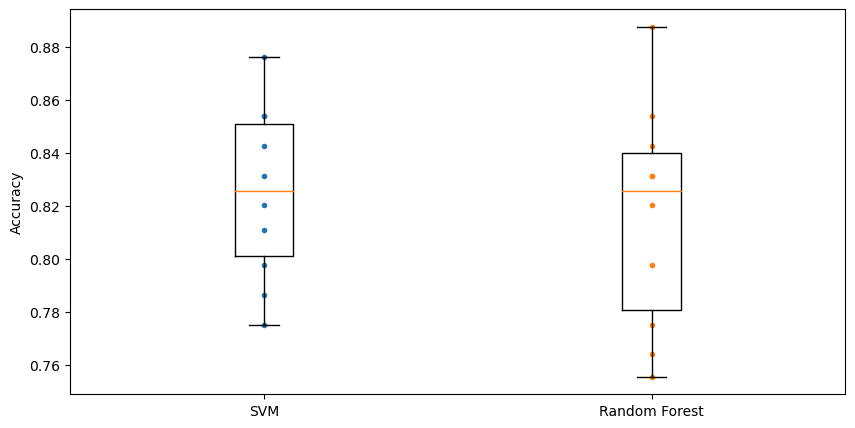

In [48]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,5))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels = ("SVM", "Random Forest"))
plt.ylabel("Accuracy")
plt.show()

In [52]:
train_data["AgeBucket"] = train_data["Age"] // 15*15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()


,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [53]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
